In [1]:
from numpy import array
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [5]:
def build_model(num_units, filter_size, n_steps, n_features):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=filter_size, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(num_units, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [6]:
def get_model_input(df, n_steps = 8,n_features = 1):
  try:
    raw_seq = df
    X, y = split_sequence(raw_seq, n_steps) 
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return raw_seq,X,y
  except:
    print("Exception for ", X)

In [7]:
df_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/partial_full.csv"
def read_df(my_path):
  df = pd.read_csv(my_path,infer_datetime_format=True)
  df["dt"] = pd.to_datetime(df["dt"])
  df = df.set_index("dt")
  df = df.sort_index()
  return df

In [8]:
df = read_df(df_path)
df = df.sort_index()
values = df["demand"].values.tolist()[0:]
train = values[:18000]
test = values[18000:]

In [9]:
def prepare_model(values, n_steps = 8, n_features = 1, n_units = 50, filter_size =64, num_epochs=200):
  raw_seq, X, y = get_model_input(values, n_steps, n_features)
  n_seq = 2
  X = X.reshape((X.shape[0], n_seq, int(n_steps/2), n_features))
  model = build_model(n_units, filter_size, int(n_steps/2), n_features)
  history = model.fit(X, y, epochs=num_epochs, verbose=0)
  return model, history

In [10]:
def predict_model(values, model,n_steps=8):
  output = pd.DataFrame()
  for i in range(len(values) - n_steps - 1):
    lst = values[i:i+n_steps]
    y = values[i+n_steps]
    x_input = np.array(lst)
    x_input = x_input.reshape((1, 2, int(n_steps/2), 1))
    yhat = model.predict(x_input, verbose=0)
    if y > 0:
      output = output.append({"Actual Demand": y, "Predicted Demand": yhat[0][0]}, ignore_index=True)
  return output

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
def evl(train, model, n_steps):
  output = predict_model(train, model, n_steps)
  #output.plot(figsize=(12,8))
  rmse=sqrt(mean_squared_error(output['Actual Demand'],output['Predicted Demand']))
  return rmse, output

In [12]:
lags = [6,8,12]
units = [20,30,40,50,60,70,80,90,100,110,120]
filters = [16,32,64,128]
hyper_param_list = []
for i in lags:
  for j in units:
    for k in filters:
      hyper_param_list.append([i,j,k])

In [ ]:
my_models = []
for item in hyper_param_list:
  model, history = prepare_model(train, n_steps=item[0], n_features=1, n_units=item[1], filter_size=item[2], num_epochs = 50)
  rmse, output = evl(test,model, n_steps=item[0])
  my_models.append({"model":model, "history":history, "rmse": rmse, "output":output})
  print(rmse, item)

7560.335981781564 [6, 20, 16]
606.4554849770251 [6, 20, 32]
7560.337000845837 [6, 20, 64]
600.7334823879436 [6, 20, 128]
600.381196641941 [6, 30, 16]
603.1051987952827 [6, 30, 32]
628.2314780544947 [6, 30, 64]
632.3329141929919 [6, 30, 128]
610.4665398381068 [6, 40, 16]
608.8735855955752 [6, 40, 32]
601.207868446447 [6, 40, 64]
619.384087781322 [6, 40, 128]
601.8431990892725 [6, 50, 16]
600.1849325223577 [6, 50, 32]
625.122959218573 [6, 50, 64]
602.2829878638344 [6, 50, 128]
602.6324305844015 [6, 60, 16]
599.9003355222885 [6, 60, 32]
616.3110157131459 [6, 60, 64]
607.2467062996423 [6, 60, 128]
613.693738957498 [6, 70, 16]
604.9485413114809 [6, 70, 32]
609.8700538257515 [6, 70, 64]
602.7843426701905 [6, 70, 128]
599.8757573386905 [6, 80, 16]
603.2809697911315 [6, 80, 32]
620.8156739854197 [6, 80, 64]
605.5003466442123 [6, 80, 128]
601.0742959146842 [6, 90, 16]
646.913400285111 [6, 90, 32]
617.1830662044284 [6, 90, 64]
605.2783898465667 [6, 90, 128]
605.7765904234248 [6, 100, 16]
604.556

In [13]:
new_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/pre_processed_mi_tail.csv"
new_df = read_df(new_path)
new_df.head()

,demand
dt,
2021-09-01 00:00:00,8874.0
2021-09-01 01:00:00,8513.0
2021-09-01 02:00:00,8446.0
2021-09-01 03:00:00,8398.0
2021-09-01 04:00:00,8164.0


In [14]:
model, history = prepare_model(train, n_steps=12, n_features=1, n_units=100, filter_size=32, num_epochs = 50)

In [17]:
rmse, output = evl(new_df["demand"].values.tolist()[0:], model, n_steps=12)
print(rmse)

375.45370598999915


Text(0, 0.5, 'Demand (MW)')

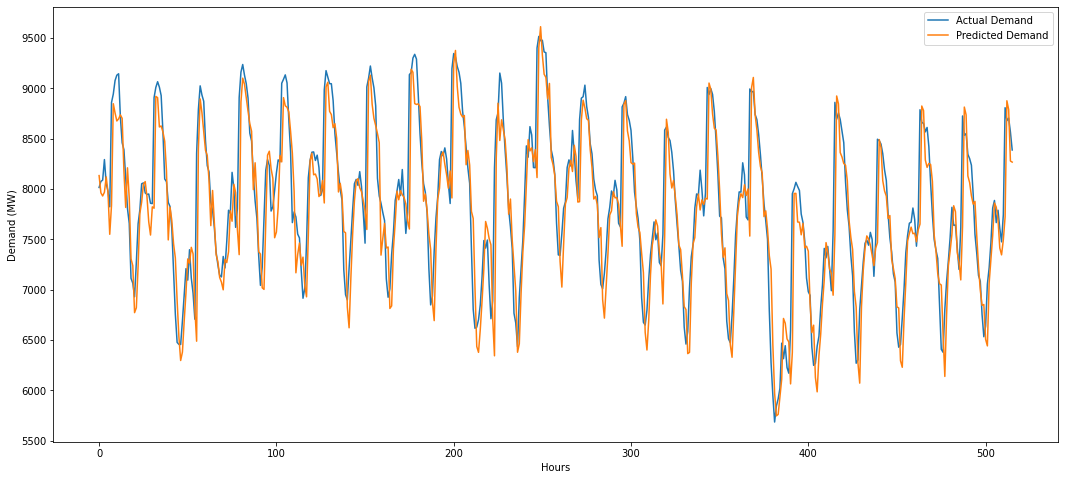

In [18]:
ax = output.plot(figsize=(18,8))
ax.set_xlabel("Hours")
ax.set_ylabel("Demand (MW)")